In [700]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [701]:
import tensorflow as tf
tf.__version__

'2.18.0'

In [702]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
# extra libraries
from scipy import stats
from scipy.stats import f_oneway, skew
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.neural_network import MLPRegressor
from keras.models import Sequential
from keras.layers import Dense, Dropout, Input


In [703]:
def wrangle(path, scaling=False):
    df=pd.read_csv(path)
    df.columns = df.columns.str.lower().str.replace(' ', '_')
    df.drop(columns=['unnamed'], inplace=True)
    # Impute missing values
    
    # Derive column 'Brand' from column: 'title'
    df.insert(1, "brand", df.apply(lambda row : row["title"].split(" ")[0].upper(), axis=1))
    # drop title column
    df = df.drop(columns=['title'])
    # Fill in Service History
    df['service_history']=df['service_history'].fillna('unknown')
    # fill in with median
    df['previous_owners'].fillna(df['previous_owners'].median(), inplace=True)
    df['doors'].fillna(df['doors'].median(), inplace=True)
    df['seats'].fillna(df['seats'].median(), inplace=True)
    # Fill missing 'emission_class' values with the most frequent category (mode)
    df['engine']=df['engine'].fillna(df['engine'].mode()[0])
    df['emission_class']=df['emission_class'].fillna(df['emission_class'].mode()[0]) 
    # put all the contents in to lower case
    categorical = list(df.dtypes[df.dtypes == 'object'].index)
    numerical = list(df.dtypes[df.dtypes != 'object'].index)
    for col in categorical:
        df[col] = df[col].str.lower().str.replace(' ', '_')
    
    
        
    
    
    
    

    return df

In [704]:
df = pd.read_csv('./data/used_cars_UK.csv')

In [705]:
df.head()

,Unnamed: 0,title,Price,Mileage(miles),Registration_Year,Previous Owners,Fuel type,Body type,Engine,Gearbox,Doors,Seats,Emission Class,Service history
0,0,SKODA Fabia,6900,70189,2016,3.0,Diesel,Hatchback,1.4L,Manual,5.0,5.0,Euro 6,NaN
1,1,Vauxhall Corsa,1495,88585,2008,4.0,Petrol,Hatchback,1.2L,Manual,3.0,5.0,Euro 4,Full
2,2,Hyundai i30,949,137000,2011,NaN,Petrol,Hatchback,1.4L,Manual,5.0,5.0,Euro 5,NaN
3,3,MINI Hatch,2395,96731,2010,5.0,Petrol,Hatchback,1.4L,Manual,3.0,4.0,Euro 4,Full
4,4,Vauxhall Corsa,1000,85000,2013,NaN,Diesel,Hatchback,1.3L,Manual,5.0,5.0,Euro 5,NaN


In [706]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3685 entries, 0 to 3684
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         3685 non-null   int64  
 1   title              3685 non-null   object 
 2   Price              3685 non-null   int64  
 3   Mileage(miles)     3685 non-null   int64  
 4   Registration_Year  3685 non-null   int64  
 5   Previous Owners    2276 non-null   float64
 6   Fuel type          3685 non-null   object 
 7   Body type          3685 non-null   object 
 8   Engine             3640 non-null   object 
 9   Gearbox            3685 non-null   object 
 10  Doors              3660 non-null   float64
 11  Seats              3650 non-null   float64
 12  Emission Class     3598 non-null   object 
 13  Service history    540 non-null    object 
dtypes: float64(3), int64(4), object(7)
memory usage: 403.2+ KB


In [707]:
df.columns.to_list()

['Unnamed: 0',
 'title',
 'Price',
 'Mileage(miles)',
 'Registration_Year',
 'Previous Owners',
 'Fuel type',
 'Body type',
 'Engine',
 'Gearbox',
 'Doors',
 'Seats',
 'Emission Class',
 'Service history']

In [708]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

In [709]:
df.head()

,unnamed:_0,title,price,mileage(miles),registration_year,previous_owners,fuel_type,body_type,engine,gearbox,doors,seats,emission_class,service_history
0,0,SKODA Fabia,6900,70189,2016,3.0,Diesel,Hatchback,1.4L,Manual,5.0,5.0,Euro 6,NaN
1,1,Vauxhall Corsa,1495,88585,2008,4.0,Petrol,Hatchback,1.2L,Manual,3.0,5.0,Euro 4,Full
2,2,Hyundai i30,949,137000,2011,NaN,Petrol,Hatchback,1.4L,Manual,5.0,5.0,Euro 5,NaN
3,3,MINI Hatch,2395,96731,2010,5.0,Petrol,Hatchback,1.4L,Manual,3.0,4.0,Euro 4,Full
4,4,Vauxhall Corsa,1000,85000,2013,NaN,Diesel,Hatchback,1.3L,Manual,5.0,5.0,Euro 5,NaN


<div style="background-color:#00008b;font-size:40px; color:white;">Data Exploration</div>

In [710]:
# Check all the values
df.describe().T

,count,mean,std,min,25%,50%,75%,max
unnamed:_0,3685.0,2314.770963,1415.821308,0.0,1059.0,2279.0,3593.0,4727.0
price,3685.0,5787.145726,4480.810572,400.0,2490.0,4000.0,7995.0,33900.0
mileage(miles),3685.0,81328.164722,39420.833595,1.0,56984.0,80000.0,103000.0,1110100.0
registration_year,3685.0,2011.835007,5.092566,1953.0,2008.0,2012.0,2015.0,2023.0
previous_owners,2276.0,2.807557,1.546028,1.0,2.0,3.0,4.0,9.0
doors,3660.0,4.321038,0.986902,2.0,3.0,5.0,5.0,5.0
seats,3650.0,4.900274,0.577200,2.0,5.0,5.0,5.0,7.0


In [711]:
len(list(df.engine.unique()))

35

In [712]:
df.engine.unique()

array(['1.4L', '1.2L', '1.3L', '2.0L', '1.6L', '2.3L', '1.8L', '1.0L',
       '3.0L', '1.5L', '1.9L', '2.4L', '2.2L', '3.5L', '3.2L', '2.5L',
       '1.1L', '3.1L', '3.7L', '2.6L', '2.1L', '2.8L', '5.0L', '0.8L',
       '2.7L', '1.7L', '0.9L', '4.2L', nan, '4.4L', '4.3L', '3.3L',
       '5.5L', '4.8L', '6.3L'], dtype=object)

In [713]:
# Columns with Null Values
df.isnull().sum()[df.isnull().sum()!=0]

previous_owners    1409
engine               45
doors                25
seats                35
emission_class       87
service_history    3145
dtype: int64

In [714]:
df.isnull().sum()/len(df)

unnamed:_0           0.000000
title                0.000000
price                0.000000
mileage(miles)       0.000000
registration_year    0.000000
previous_owners      0.382361
fuel_type            0.000000
body_type            0.000000
engine               0.012212
gearbox              0.000000
doors                0.006784
seats                0.009498
emission_class       0.023609
service_history      0.853460
dtype: float64

In [715]:
# Columns with Null Values
df.isnull().sum()[df.isnull().sum()!=0].index

Index(['previous_owners', 'engine', 'doors', 'seats', 'emission_class',
       'service_history'],
      dtype='object')

In [716]:
# Fill in Service History
df['service_history']=df['service_history'].fillna('unknown')

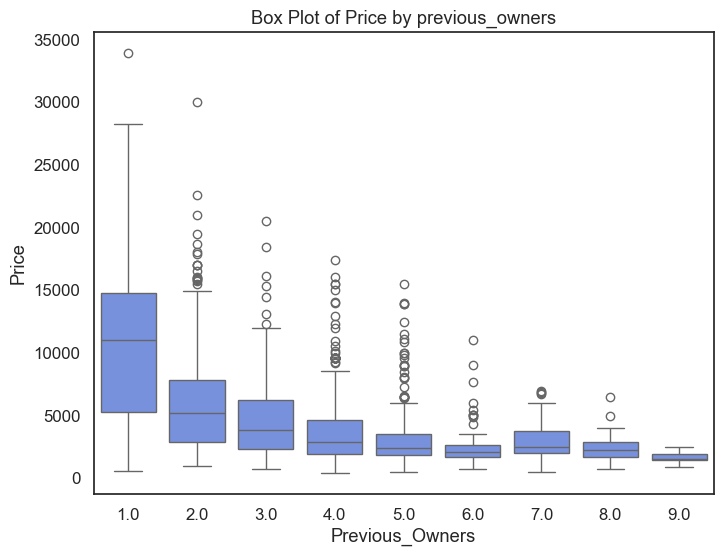

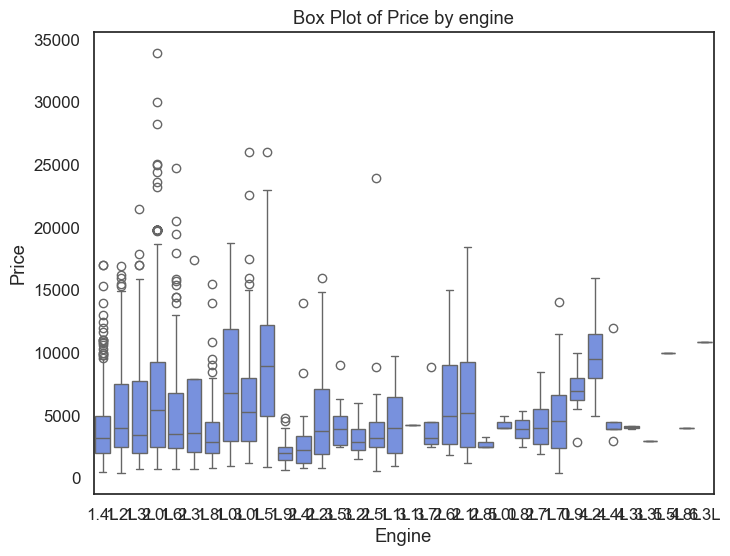

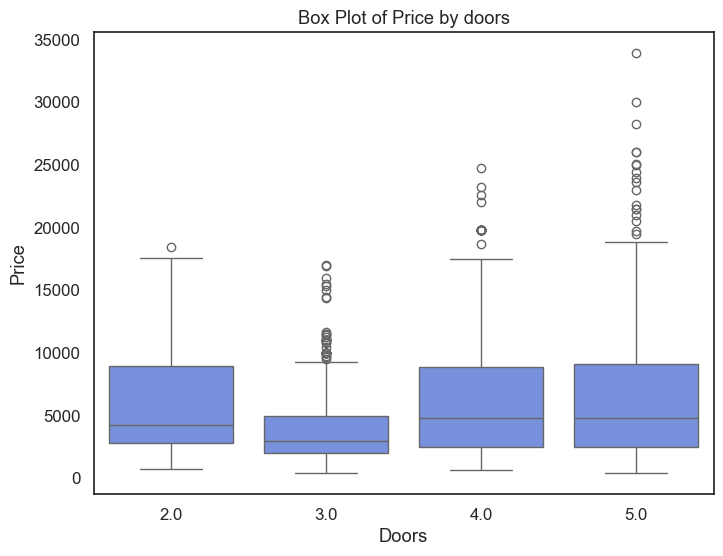

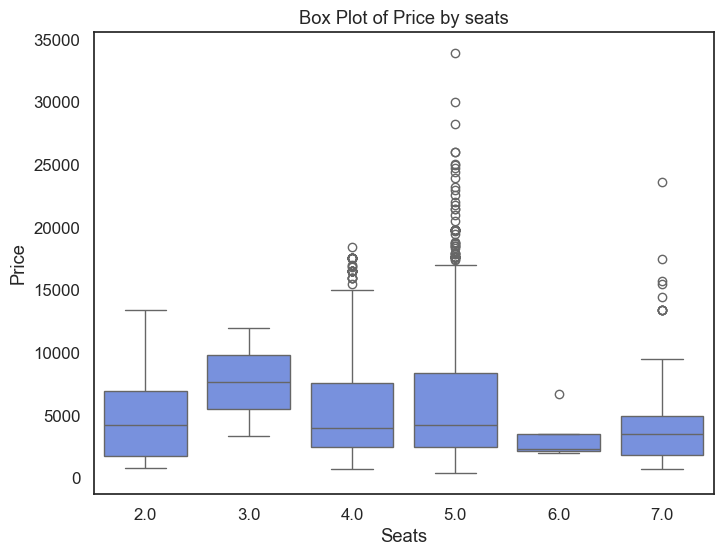

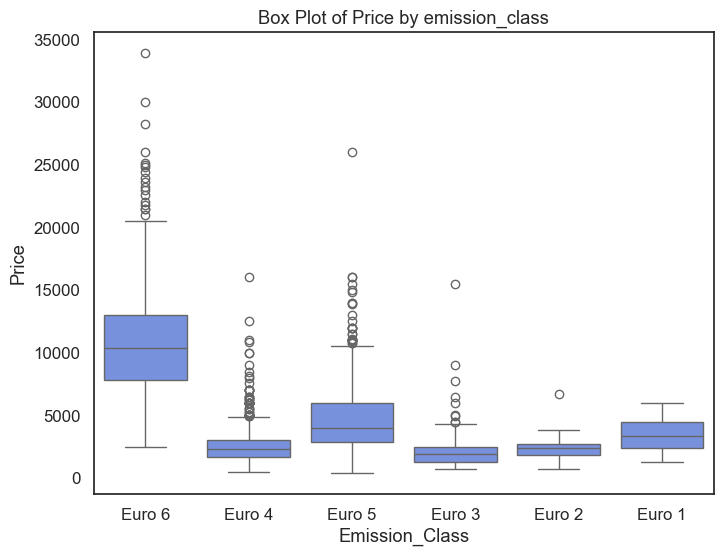

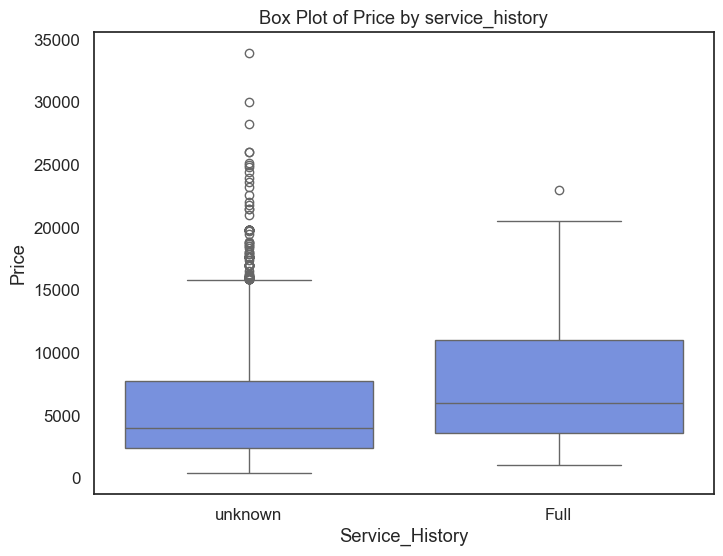

In [717]:
missing_cols=['previous_owners', 'engine', 'doors', 'seats', 'emission_class','service_history']

for col in missing_cols:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x=col, y='price', data=df)
    plt.xlabel(col.title())
    plt.ylabel('Price')
    plt.title(f'Box Plot of Price by {col}')
    plt.show()


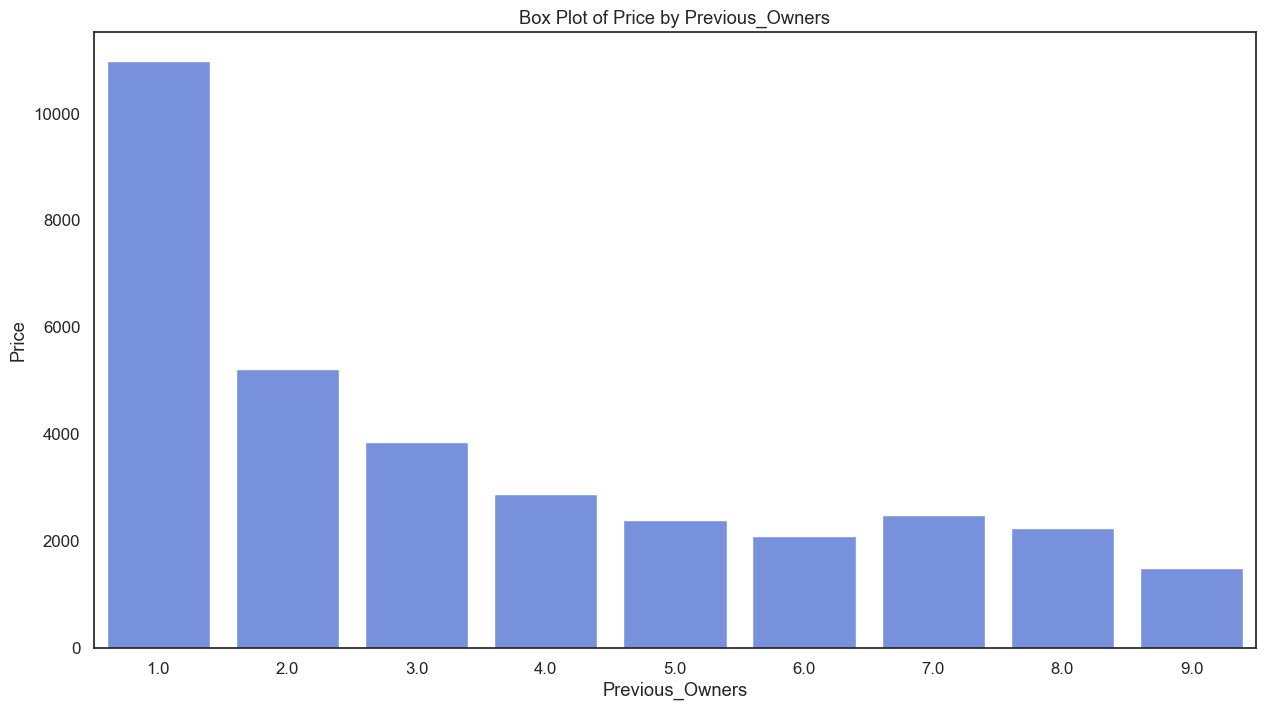

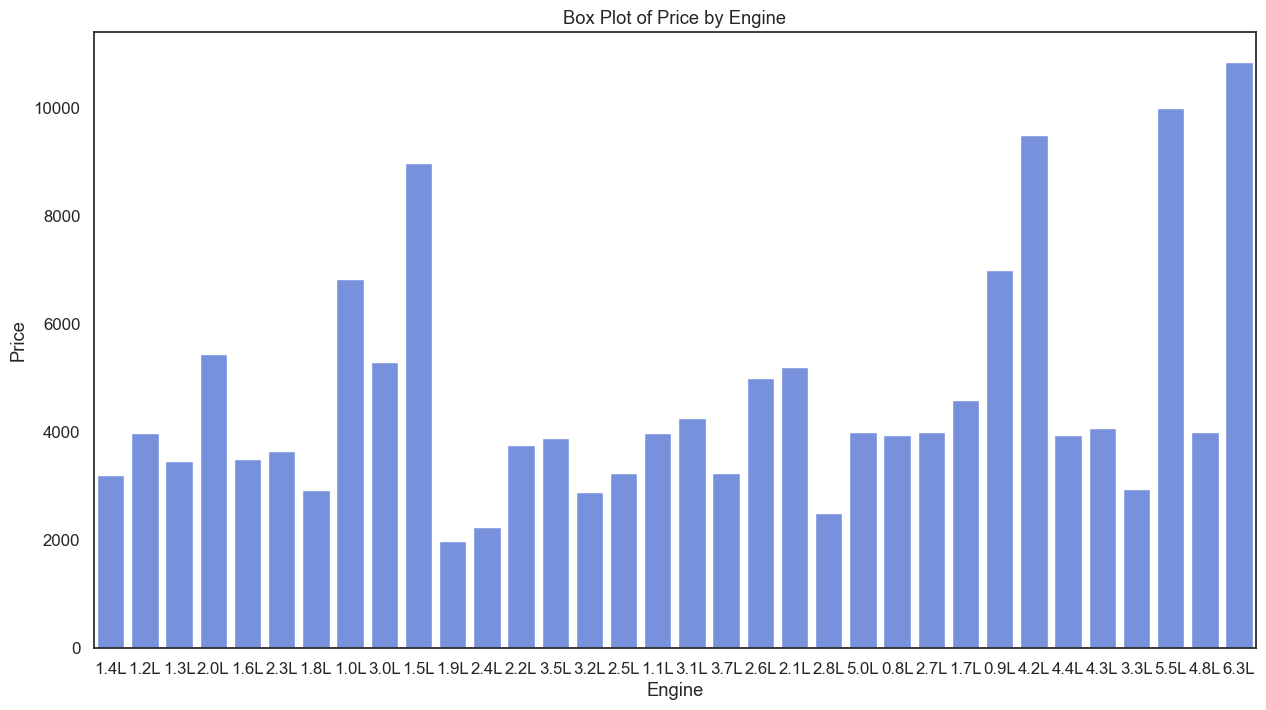

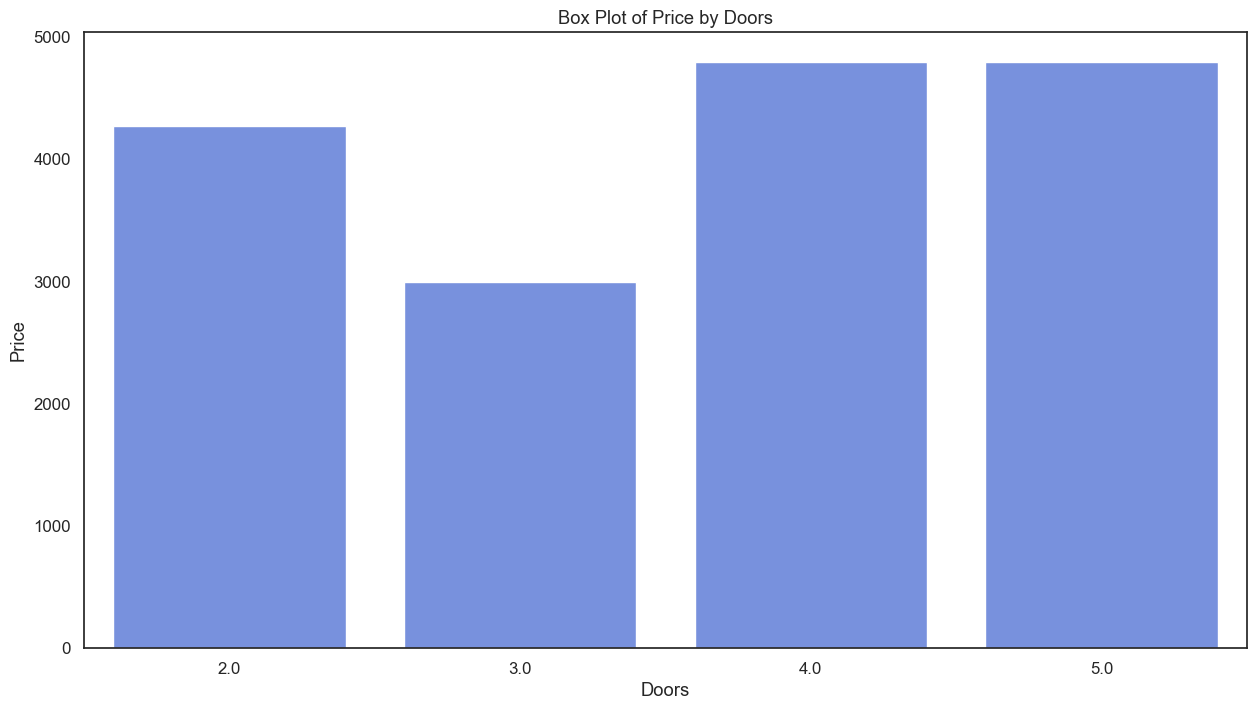

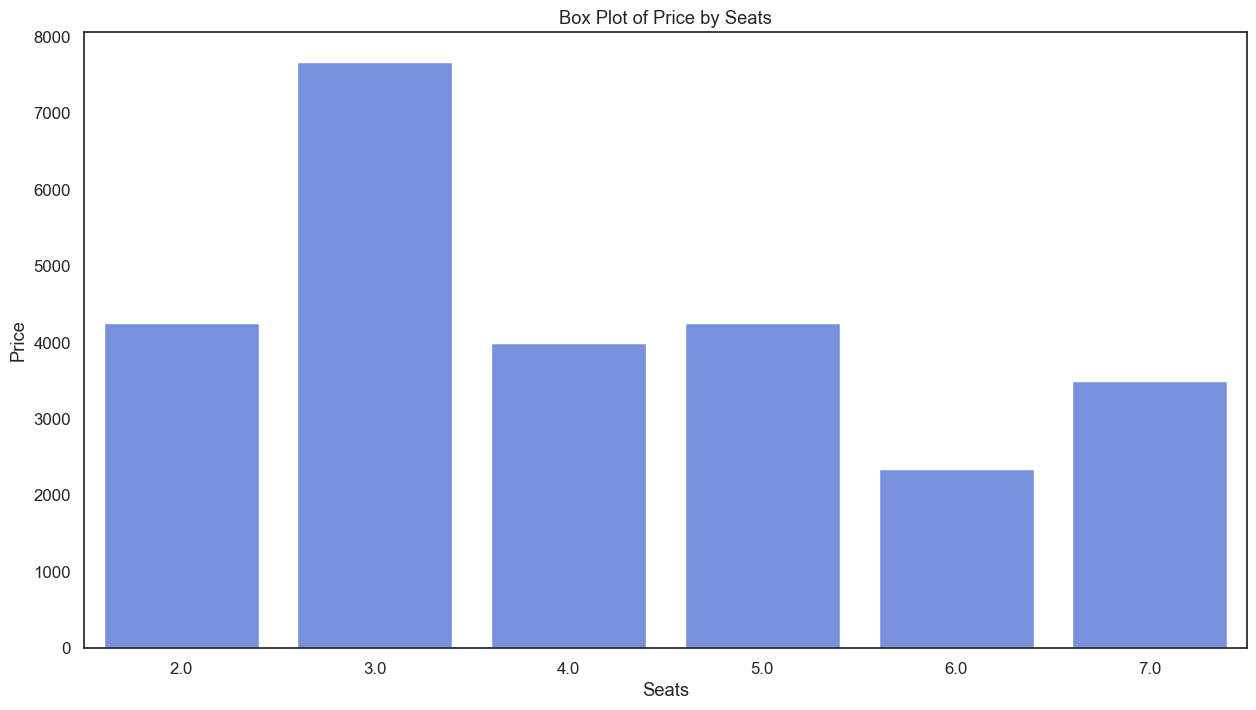

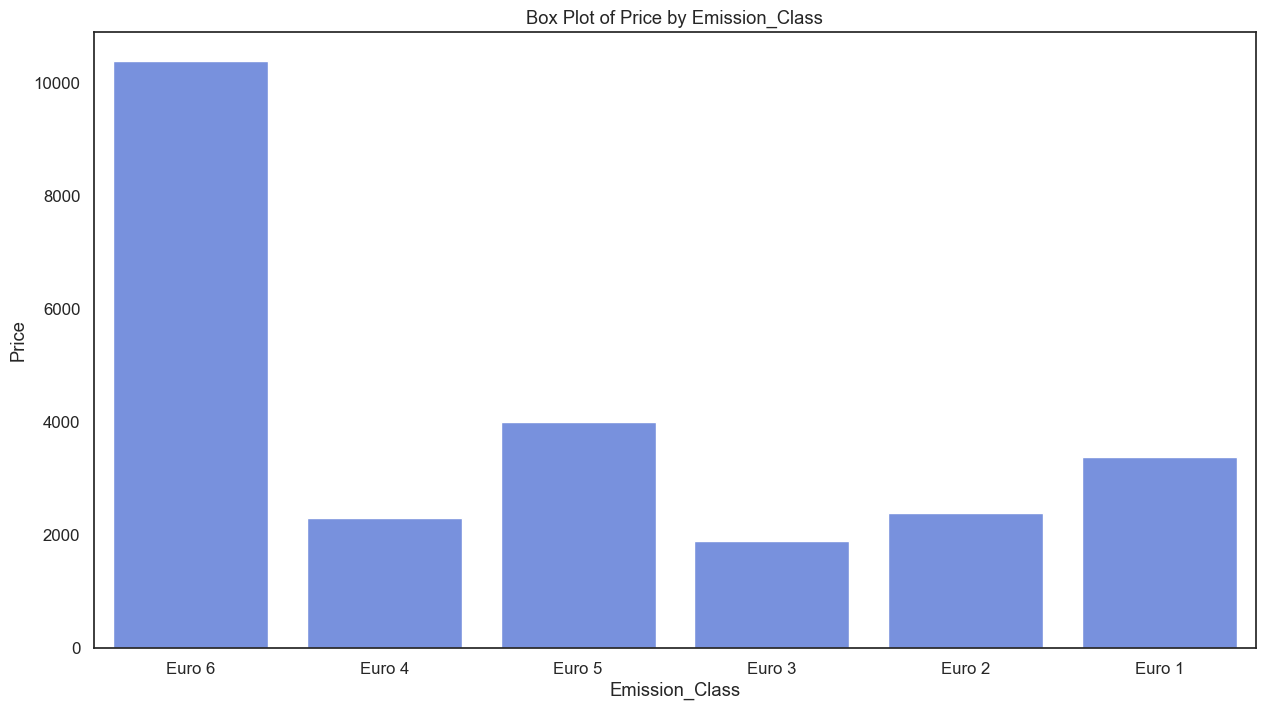

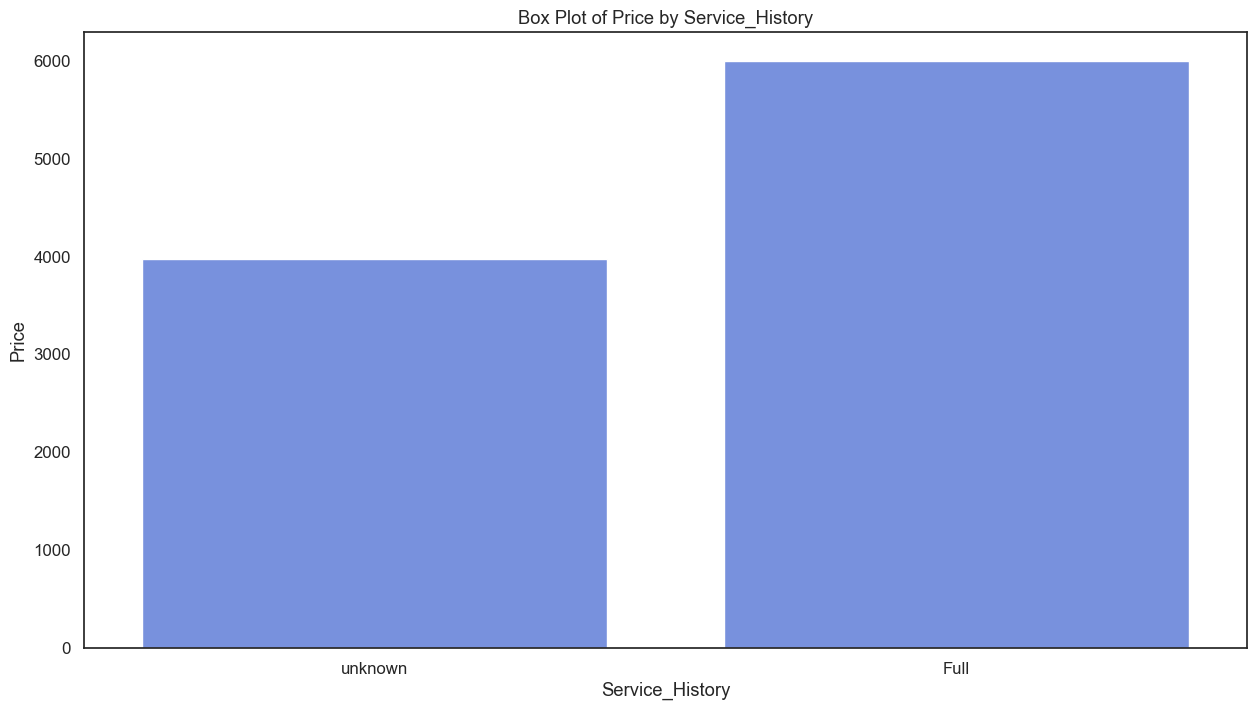

In [718]:
missing_cols=['previous_owners', 'engine', 'doors', 'seats', 'emission_class','service_history']

for col in missing_cols:
    plt.figure(figsize=(15, 8))
    sns.barplot(x=col, y='price', data=df, estimator='median', errorbar=None)
    plt.xlabel(col.title())
    plt.ylabel('Price')
    plt.title(f'Box Plot of Price by {col.title()}')
    plt.show()


In [719]:
# Service History has 85% missing and unamed is just an extra column, so both dropped
df.drop(['unnamed:_0'], axis=1, inplace=True)

In [720]:
df.head()

,title,price,mileage(miles),registration_year,previous_owners,fuel_type,body_type,engine,gearbox,doors,seats,emission_class,service_history
0,SKODA Fabia,6900,70189,2016,3.0,Diesel,Hatchback,1.4L,Manual,5.0,5.0,Euro 6,unknown
1,Vauxhall Corsa,1495,88585,2008,4.0,Petrol,Hatchback,1.2L,Manual,3.0,5.0,Euro 4,Full
2,Hyundai i30,949,137000,2011,NaN,Petrol,Hatchback,1.4L,Manual,5.0,5.0,Euro 5,unknown
3,MINI Hatch,2395,96731,2010,5.0,Petrol,Hatchback,1.4L,Manual,3.0,4.0,Euro 4,Full
4,Vauxhall Corsa,1000,85000,2013,NaN,Diesel,Hatchback,1.3L,Manual,5.0,5.0,Euro 5,unknown


In [721]:
# Impute missing values


In [722]:
# columns with missing values
# Columns with Null Values
missing_cols=df.isnull().sum()[df.isnull().sum()!=0].index.to_list()
print(missing_cols)
# drop categorical missing columns
# drop engine
del missing_cols[1]
# drop emission_class
del missing_cols[3]

['previous_owners', 'engine', 'doors', 'seats', 'emission_class']


In [723]:
missing_cols

['previous_owners', 'doors', 'seats']

previous_owners Skewness: 0.8450023547312594


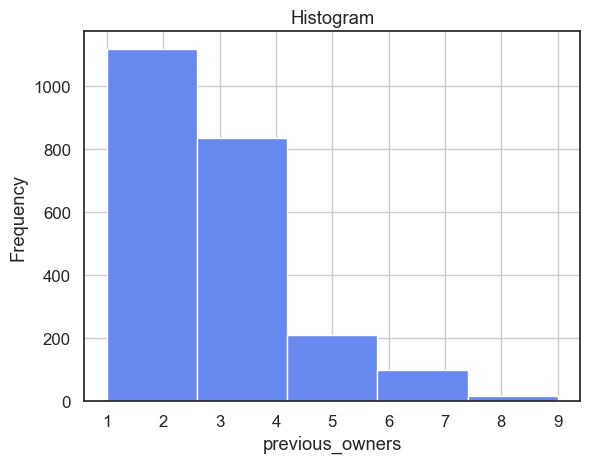

doors Skewness: -1.0453034112289992


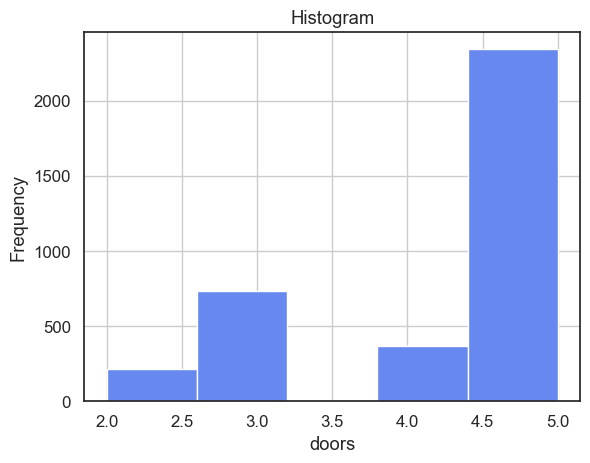

seats Skewness: 0.16730060071794964


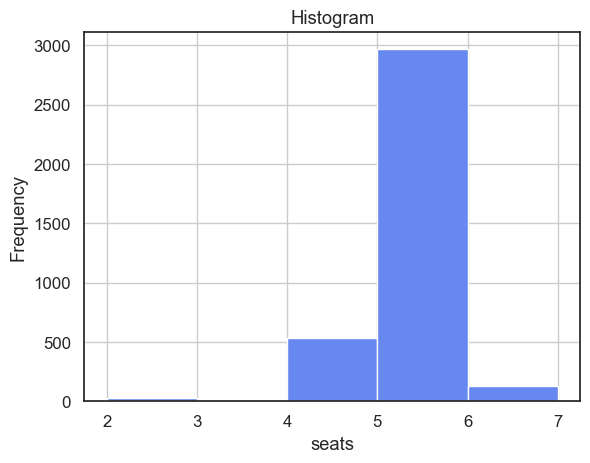

In [724]:
# Visualise the distribution
for col in missing_cols:
    # Plot histogram
    df[col].hist(bins=5)
    plt.title("Histogram")
    skewness = df[col].skew()
    print(f"{col} Skewness: {skewness}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.show()

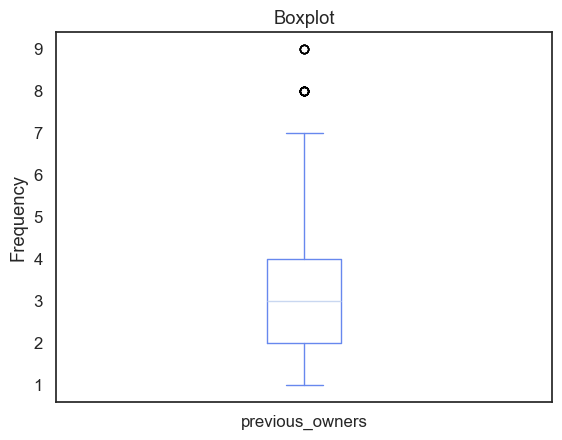

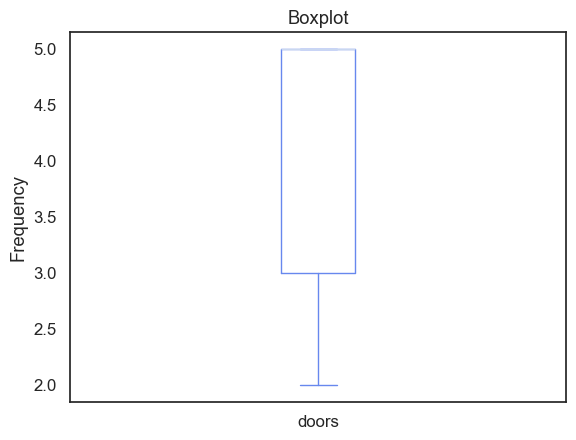

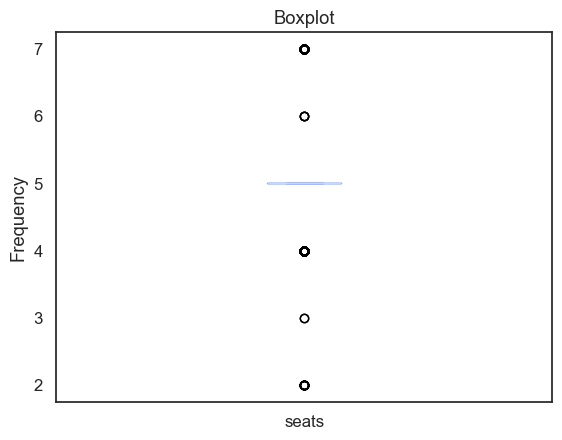

In [725]:
# Visualise the distribution
for col in missing_cols:
    # Plot histogram
    df[col].plot(kind='box')
    plt.title("Boxplot")
    plt.ylabel("Frequency")
    plt.show()

In [726]:
# Check skewness and fill missing values with median if skewed
skewness=df[missing_cols].skew()
for column in missing_cols:
    if skewness[column] > 0.5:  # Right skewed
        print(f"{column} is positively skewed. Filling missing values with the median.")
        df[column].fillna(df[column].median(), inplace=True)
    elif skewness[column] < -0.5:  # Left skewed
        print(f"{column} is negatively skewed. Filling missing values with the median.")
        df[column].fillna(df[column].median(), inplace=True)
    else:
        print(f"{column} is not significantly skewed. Filling missing values with the median.")
        df[column].fillna(df[column].median(), inplace=True)

previous_owners is positively skewed. Filling missing values with the median.
doors is negatively skewed. Filling missing values with the median.
seats is not significantly skewed. Filling missing values with the median.


In [727]:
# Fill missing 'emission_class' values with the most frequent category (mode)
df['engine']=df['engine'].fillna(df['engine'].mode()[0])
df['emission_class']=df['emission_class'].fillna(df['emission_class'].mode()[0])

In [728]:
df.isnull().sum()

title                0
price                0
mileage(miles)       0
registration_year    0
previous_owners      0
fuel_type            0
body_type            0
engine               0
gearbox              0
doors                0
seats                0
emission_class       0
service_history      0
dtype: int64

In [729]:
df.duplicated().sum()

826

In [730]:
df.drop_duplicates(inplace=True)

In [731]:
df.shape

(2859, 13)

In [732]:
df.tail()

,title,price,mileage(miles),registration_year,previous_owners,fuel_type,body_type,engine,gearbox,doors,seats,emission_class,service_history
3680,Renault Megane,1395,76202,2006,4.0,Petrol,Hatchback,1.6L,Manual,5.0,5.0,Euro 4,unknown
3681,Audi A4,6990,119000,2012,3.0,Petrol,Saloon,2.0L,Manual,4.0,5.0,Euro 5,unknown
3682,BMW 3 Series,3995,139000,2013,3.0,Diesel,Saloon,2.0L,Manual,4.0,5.0,Euro 5,unknown
3683,Honda Accord,1390,179190,2007,3.0,Diesel,Estate,2.2L,Manual,5.0,5.0,Euro 4,Full
3684,Vauxhall Corsa,2000,82160,2013,7.0,Petrol,Hatchback,1.2L,Manual,5.0,5.0,Euro 5,unknown


### Unique Values in Categorical Features

In [733]:
for col in df.columns:
    print(col)
    print(df[col].unique()[0:])
    print(df[col].nunique())
    print()

title
['SKODA Fabia' 'Vauxhall Corsa' 'Hyundai i30' 'MINI Hatch' 'Hyundai Coupe'
 'Ford Focus' 'Volvo 740' 'Peugeot 207' 'Ford Fiesta' 'Vauxhall Insignia'
 'BMW 3 Series' 'Citroen C1' 'Citroen C4' 'Vauxhall Astra' 'Ford Mondeo'
 'Mercedes-Benz A180' 'Peugeot 407' 'Ford KA' 'Mercedes-Benz A Class'
 'Mazda Mazda2' 'Saab 9-3' 'Volkswagen Polo' 'BMW 1 Series' 'Honda Accord'
 'Volkswagen Beetle' 'MG MG6' 'Ford C-max' 'Honda Civic' 'Toyota Auris'
 'Volvo S40' 'SEAT Ibiza' 'Peugeot 308' 'Vauxhall Meriva'
 'Mercedes-Benz B Class' 'Mazda Mazda3' 'Nissan 350 Z' 'Alfa Romeo Mito'
 'Renault Fluence' 'Volkswagen Passat' 'KIA Sportage' 'Citroen XM'
 'Vauxhall Antara' 'Nissan Note' 'BMW 5 Series' 'Honda Cr-v'
 'Proton Savvy' 'Nissan Micra' 'Fiat Panda' 'Renault Megane'
 'Renault Clio' 'Hyundai i20' 'Citroen C3' 'Audi A6 Saloon' 'Toyota Yaris'
 'Fiat 500' 'Mercedes-Benz M Class' 'Audi A4' 'Peugeot 308 SW'
 'Ford S-max' 'Peugeot 1007' 'Honda Odyssey' 'Peugeot 307 CC' 'Honda Jazz'
 'Mercedes-Benz CLK' '

### Checking for Outliers

In [734]:
### Skewness check for price
# Calculate skewness
skewness = df['price'].skew()
print(f"Price Skewness: {skewness}")

Price Skewness: 1.6794462567163226


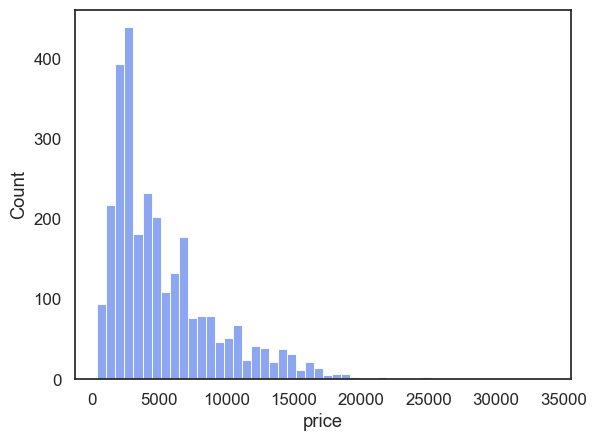

In [735]:
sns.histplot(df.price, bins=50)
plt.savefig('price_dist');

In [736]:
# Transforming to deal with skewness
price_logs = np.log1p(df.price)
price_logs.skew()  # no skewness

0.04795827650688819

<Axes: xlabel='price', ylabel='Count'>

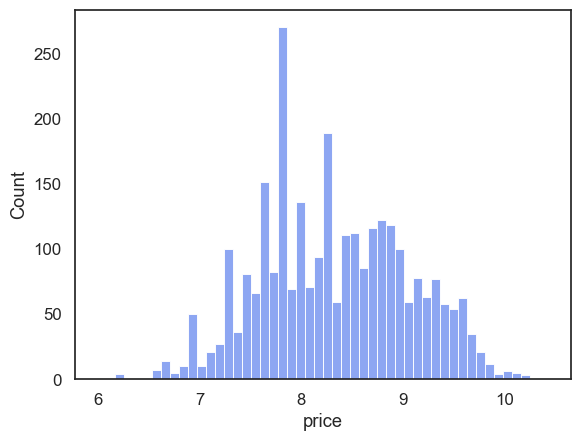

In [737]:
sns.histplot(price_logs, bins=50)

### Feature Engineering

In [738]:
# Derive column 'Brand' from column: 'title'
df.insert(1, "brand", df.apply(lambda row : row["title"].split(" ")[0].upper(), axis=1))
# drop title column
df = df.drop(columns=['title'])

In [739]:
### Converting engine size to numerical feature

In [740]:
# # Derive column 'engine_size' from column: 'engine'
# df.insert(7, "engine_size", df.apply(lambda row : row["engine"].split("L")[0].upper(), axis=1))
# # drop title column
# # Step 2: Convert the 'engine_size' column to float
# df["engine_size"] = df["engine_size"].astype(float)
# df = df.drop(columns=['engine'])

In [741]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2859 entries, 0 to 3684
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   brand              2859 non-null   object 
 1   price              2859 non-null   int64  
 2   mileage(miles)     2859 non-null   int64  
 3   registration_year  2859 non-null   int64  
 4   previous_owners    2859 non-null   float64
 5   fuel_type          2859 non-null   object 
 6   body_type          2859 non-null   object 
 7   engine             2859 non-null   object 
 8   gearbox            2859 non-null   object 
 9   doors              2859 non-null   float64
 10  seats              2859 non-null   float64
 11  emission_class     2859 non-null   object 
 12  service_history    2859 non-null   object 
dtypes: float64(3), int64(3), object(7)
memory usage: 312.7+ KB


In [742]:
df.brand.nunique()

48

In [743]:
categorical = list(df.dtypes[df.dtypes == 'object'].index)
numerical = [x for x in list(df.dtypes[df.dtypes != 'object'].index) if x !='price']
numerical, categorical

(['mileage(miles)', 'registration_year', 'previous_owners', 'doors', 'seats'],
 ['brand',
  'fuel_type',
  'body_type',
  'engine',
  'gearbox',
  'emission_class',
  'service_history'])

In [744]:
for col in categorical:
    df[col] = df[col].str.lower().str.replace(' ', '_')

In [745]:
len(categorical + numerical)

12

In [746]:
numerical

['mileage(miles)', 'registration_year', 'previous_owners', 'doors', 'seats']

<div style="background-color:#00008b;font-size:40px; color:white;">Correlation</div>

### Numerical Features with Price

mileage(miles)


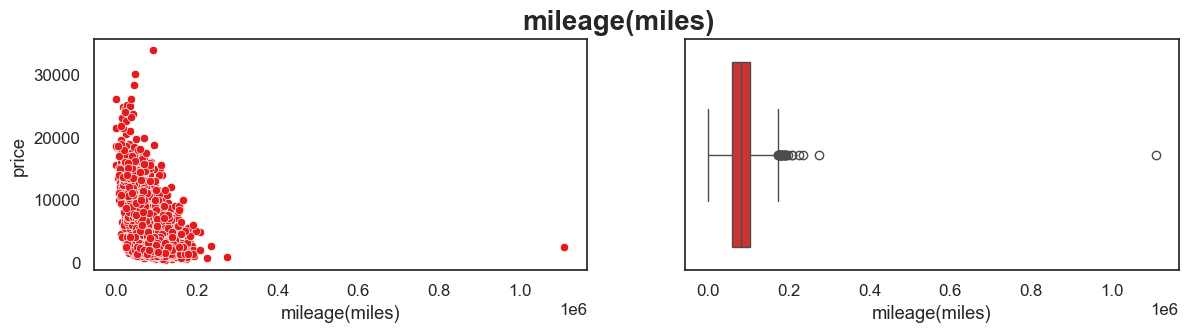

registration_year


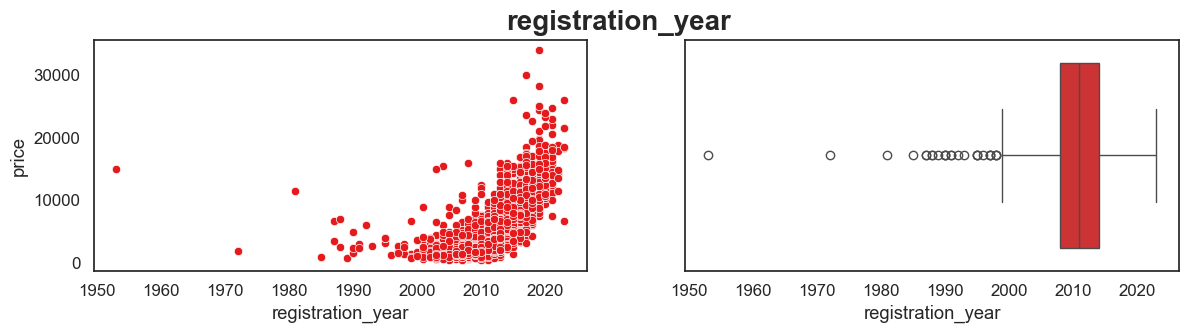

previous_owners


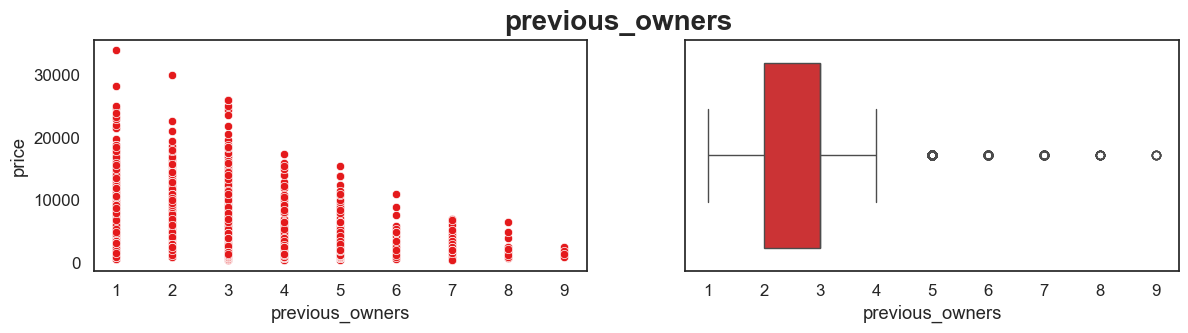

doors


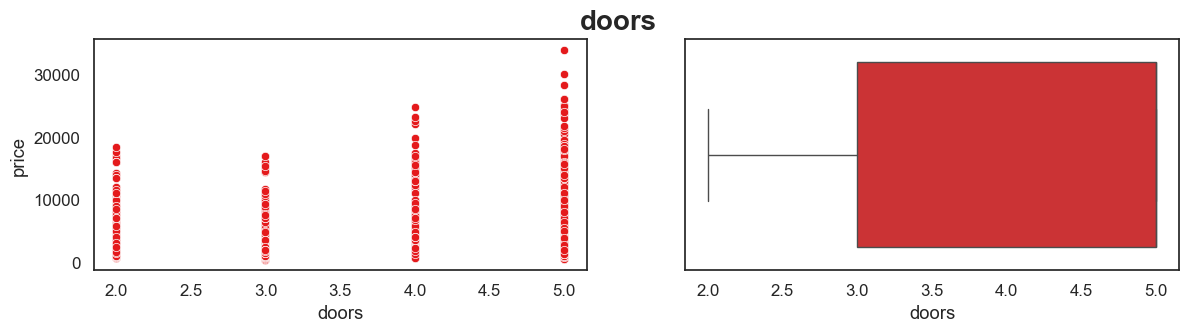

seats


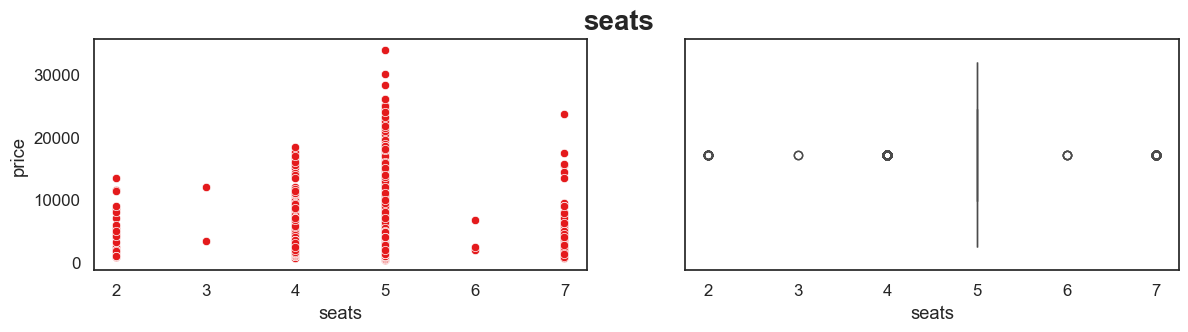

In [747]:

for feature in numerical:
    print(feature)
    fig = plt.figure(figsize=(14, 3))
    sns.set_palette("Set1")
    plt.suptitle(feature, size=20, weight='bold')
    
    plt.subplot(1, 2, 1)
    sns.scatterplot(x=feature, y='price', data=df)
    
    plt.subplot(1, 2, 2)
    ax = sns.boxplot(x=feature, data=df)
    
    plt.show()

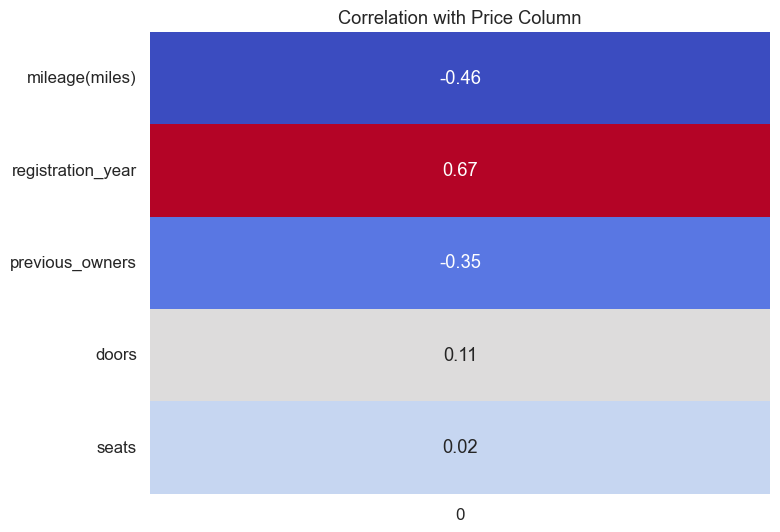

In [748]:
target_corr = df[numerical].corrwith(df['price'])

# Plot korelasi dengan heatmap
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.1)
sns.set_style("white")
sns.set_palette("PuBuGn_d")
sns.heatmap(target_corr.to_frame(), cmap="coolwarm", annot=True, fmt='.2f', cbar=False)
plt.title('Correlation with Price Column')
plt.show()


### Categorical Features with Price

In [749]:
# condider having engine size as numerical after evaluating the model

brand


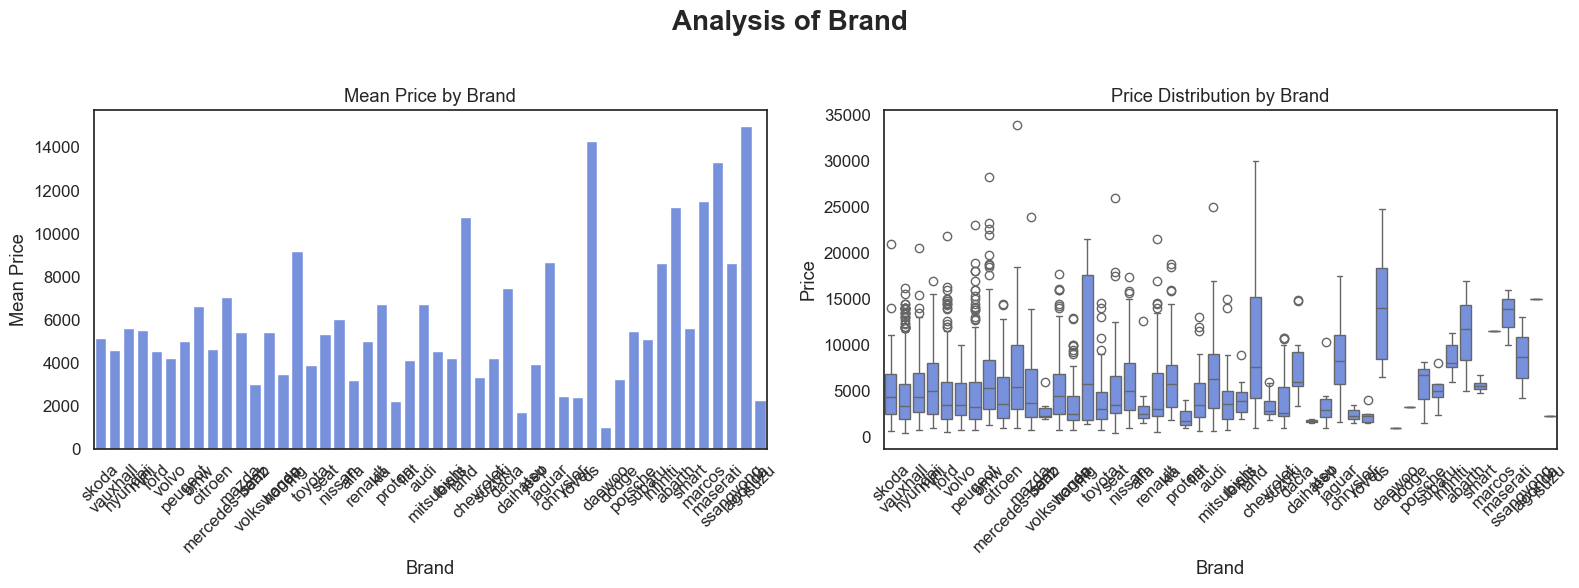

fuel_type


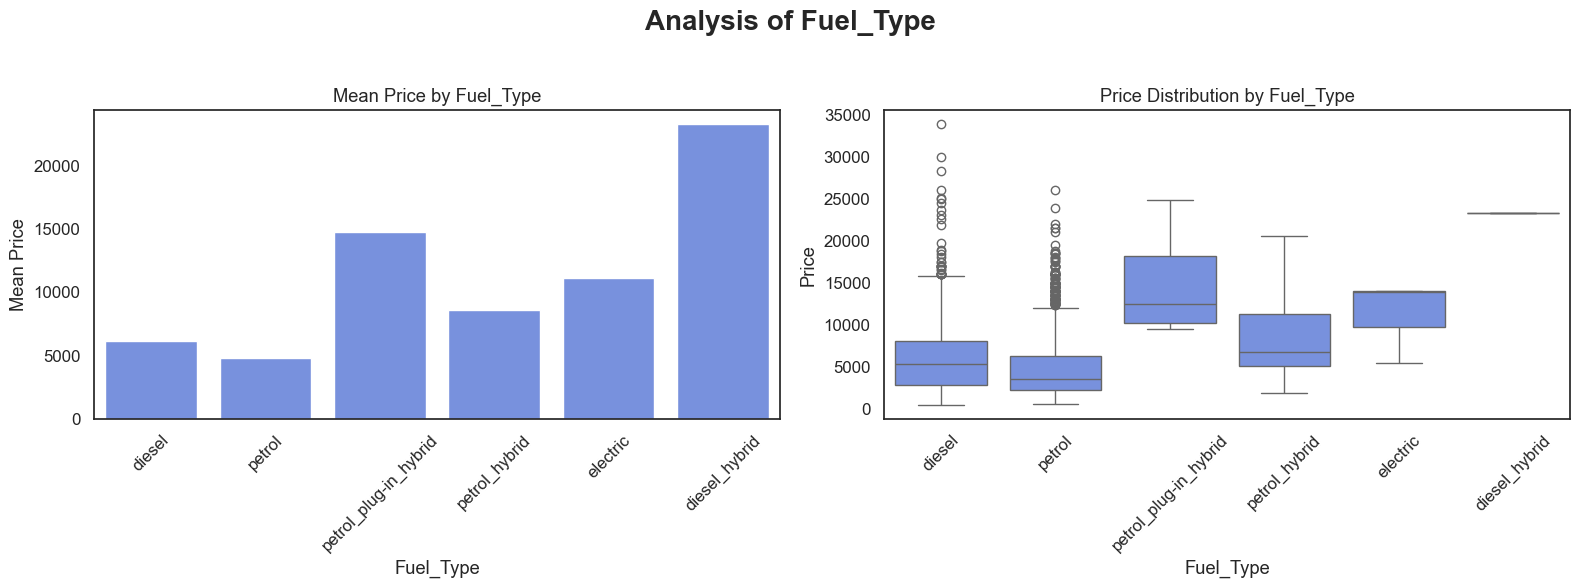

body_type


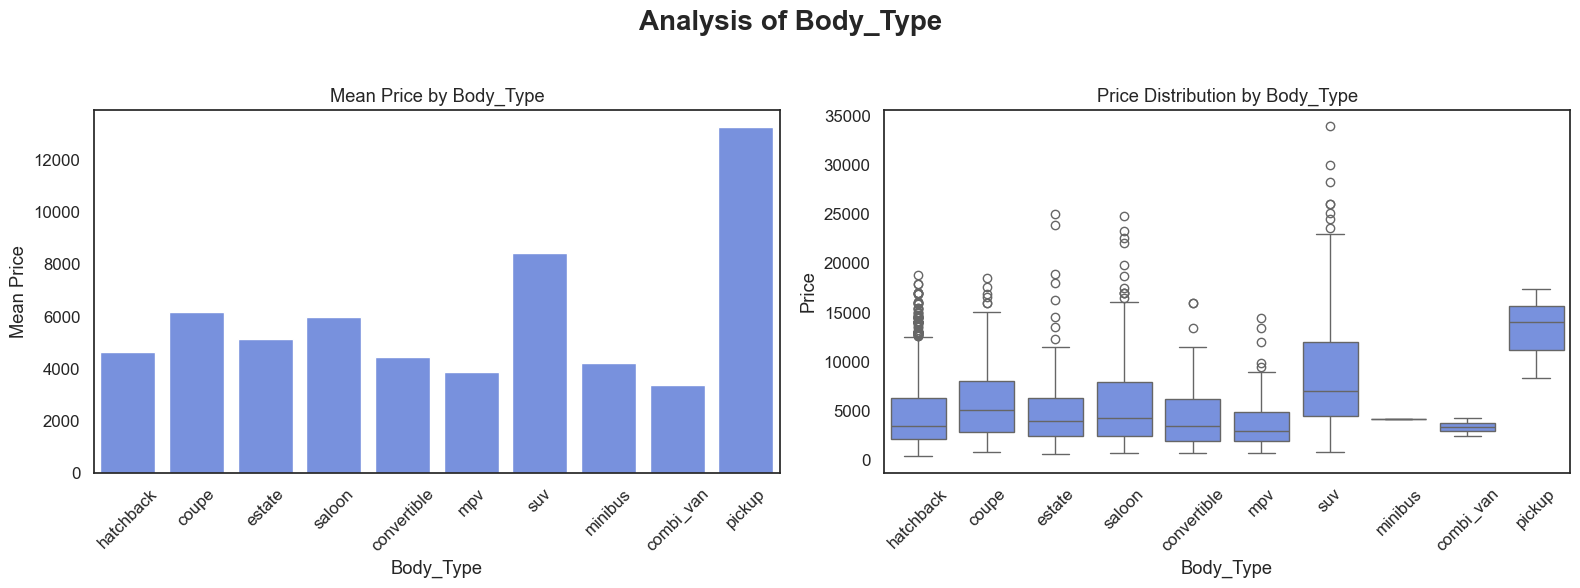

engine


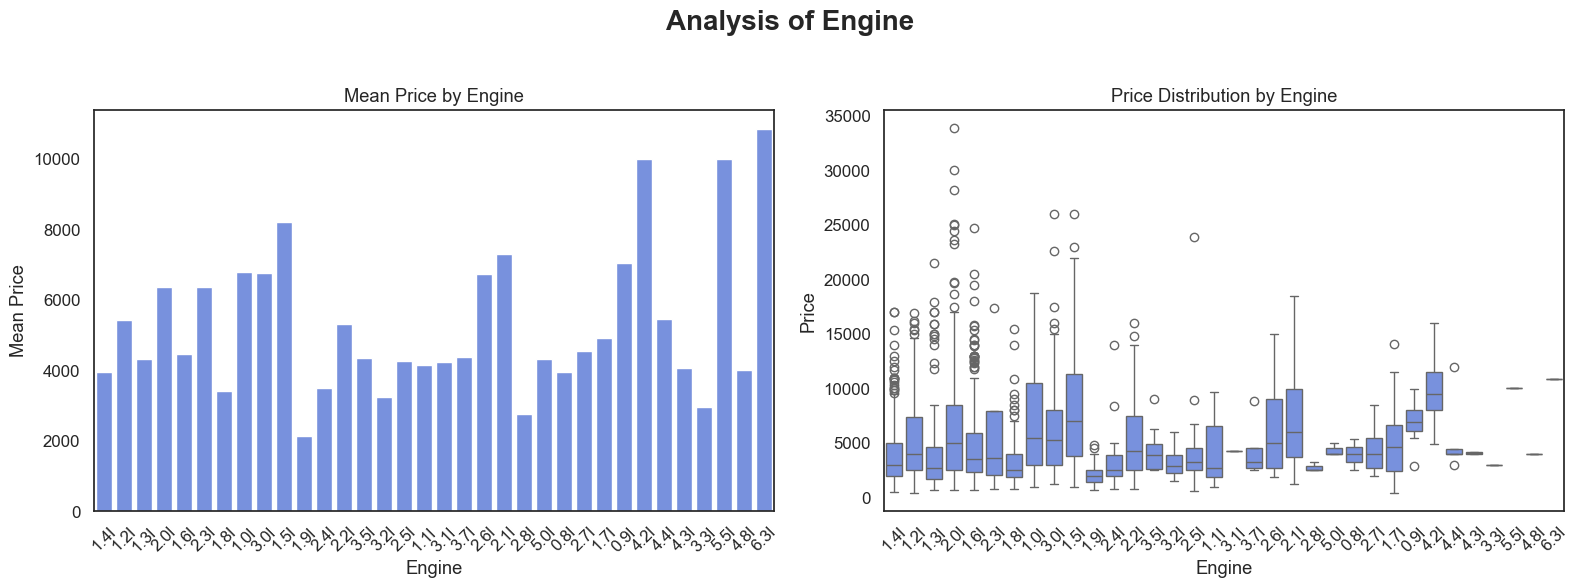

gearbox


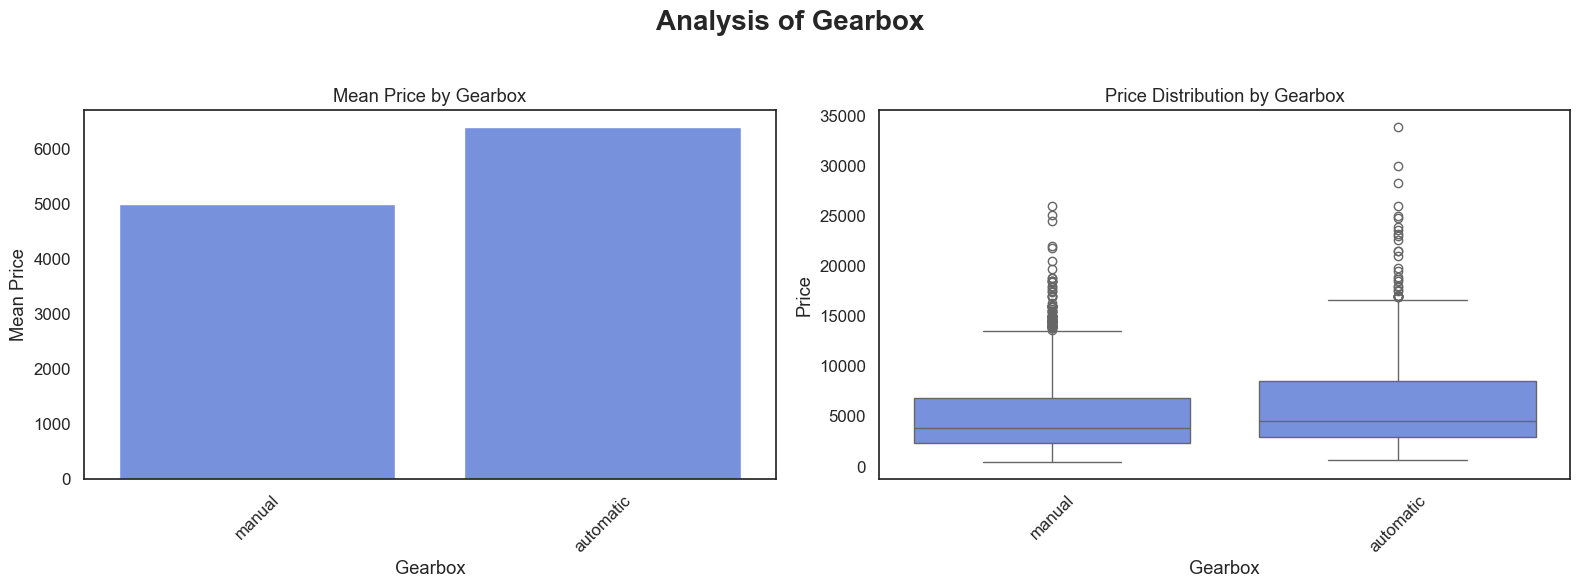

emission_class


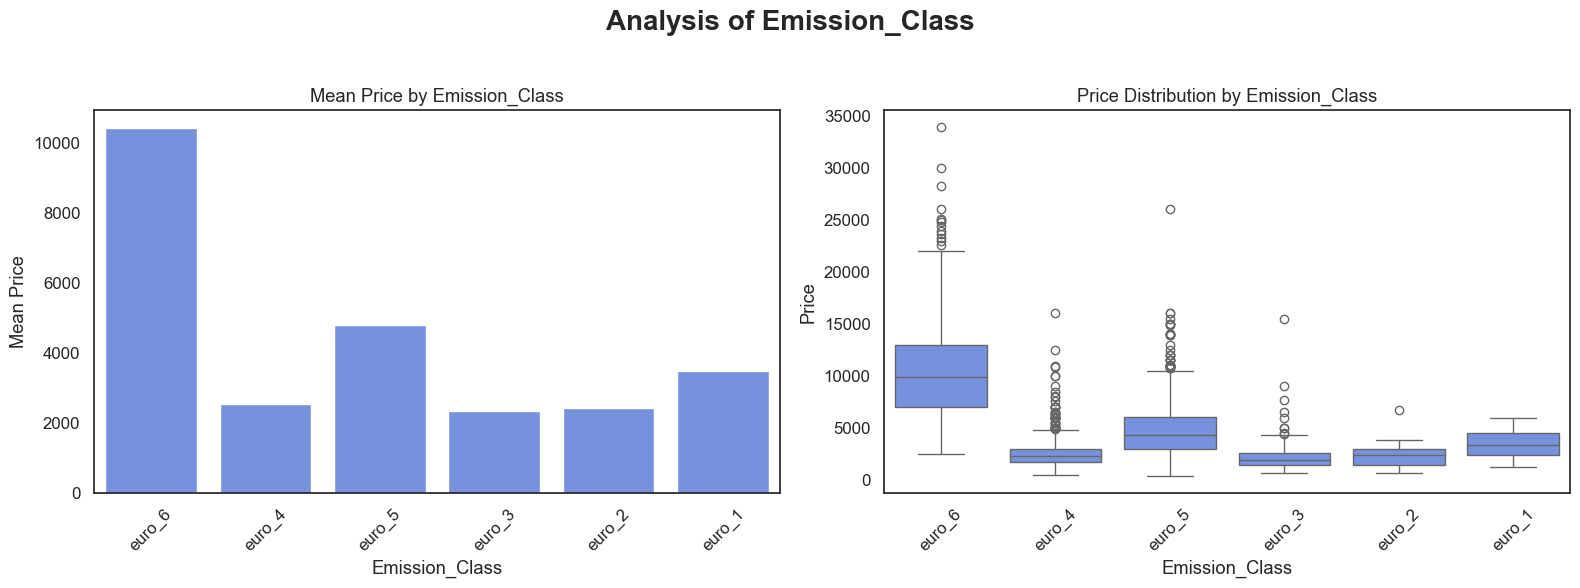

service_history


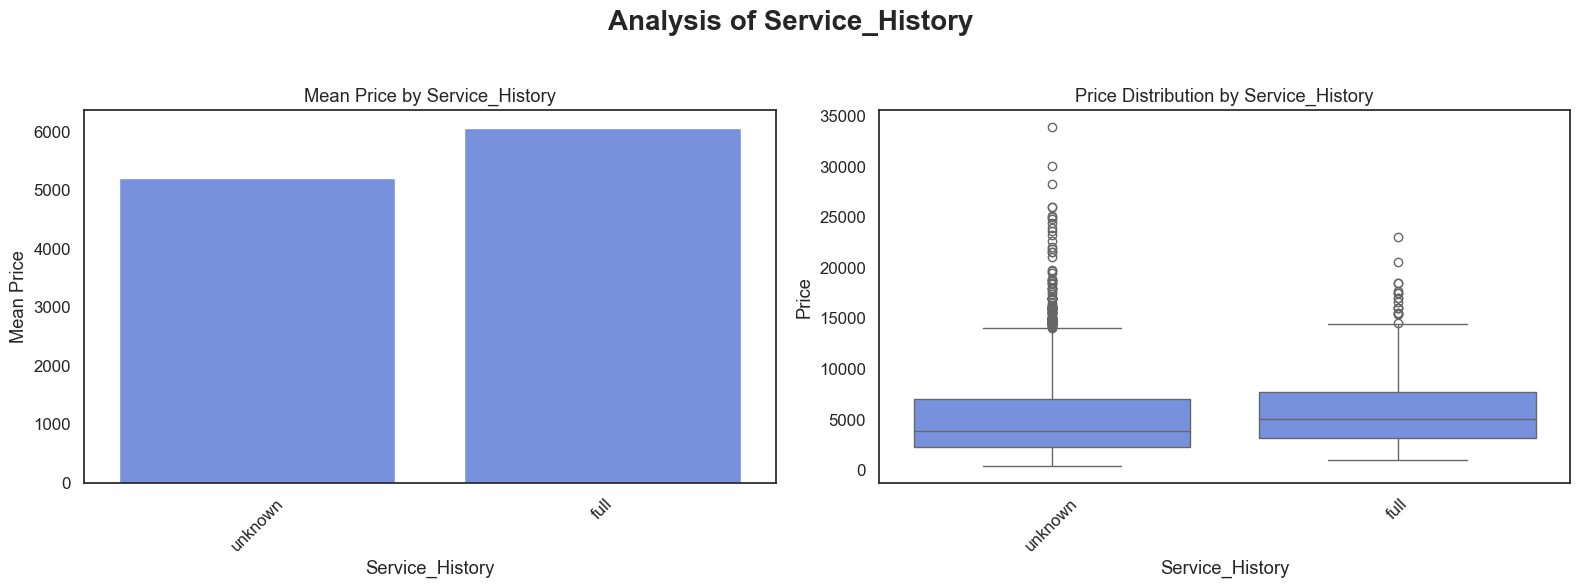

In [750]:
for feature in categorical:
    print(feature)
    fig = plt.figure(figsize=(16, 6))
    sns.set_palette("coolwarm")  # Change color palette to "coolwarm"
    plt.suptitle(f"Analysis of {feature.title()}", size=20, weight='bold')
    
    # First subplot: Barplot with mean price
    plt.subplot(1, 2, 1)
    sns.barplot(x=feature, y='price', data=df, errorbar=None, estimator=np.mean)
    plt.title(f"Mean Price by {feature.title()}")
    plt.xlabel(feature.title())
    plt.ylabel("Mean Price")
    plt.xticks(rotation=45)

    # Second subplot: Boxplot of price distribution
    plt.subplot(1, 2, 2)
    sns.boxplot(x=feature, y='price', data=df)
    plt.title(f"Price Distribution by {feature.title()}")
    plt.xlabel(feature.title())
    plt.ylabel("Price")
    plt.xticks(rotation=45)
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit the suptitle
    plt.show()


In [751]:

def count_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return ((series < lower_bound) | (series > upper_bound)).sum()

for feature in numerical :
    num_outliers = count_outliers(df[feature])
    print(f'Number of outliers in {feature}: {num_outliers}')

Number of outliers in mileage(miles): 25
Number of outliers in registration_year: 26
Number of outliers in previous_owners: 281
Number of outliers in doors: 0
Number of outliers in seats: 539


In [752]:
df.tail()

,brand,price,mileage(miles),registration_year,previous_owners,fuel_type,body_type,engine,gearbox,doors,seats,emission_class,service_history
3680,renault,1395,76202,2006,4.0,petrol,hatchback,1.6l,manual,5.0,5.0,euro_4,unknown
3681,audi,6990,119000,2012,3.0,petrol,saloon,2.0l,manual,4.0,5.0,euro_5,unknown
3682,bmw,3995,139000,2013,3.0,diesel,saloon,2.0l,manual,4.0,5.0,euro_5,unknown
3683,honda,1390,179190,2007,3.0,diesel,estate,2.2l,manual,5.0,5.0,euro_4,full
3684,vauxhall,2000,82160,2013,7.0,petrol,hatchback,1.2l,manual,5.0,5.0,euro_5,unknown


### Correlation

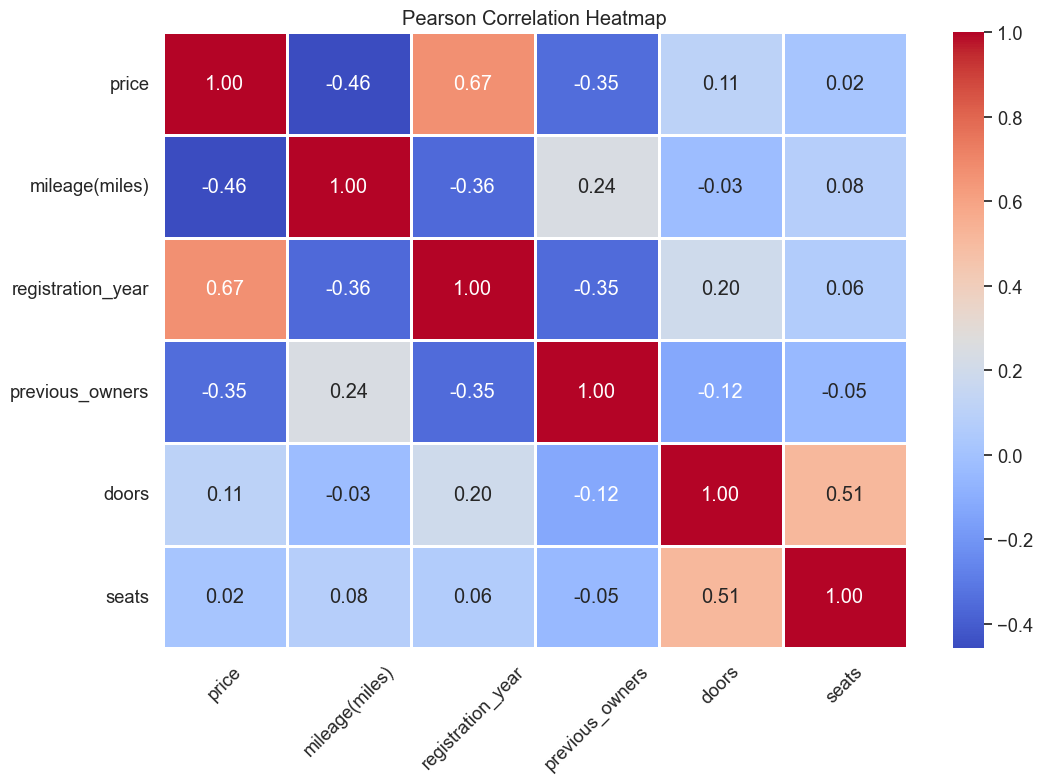

In [753]:
pearson_corr = df.corr(numeric_only=True)

plt.figure(figsize=(12, 8))
sns.set(font_scale=1.2)
sns.heatmap(pearson_corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=1, linecolor='white')
plt.title('Pearson Correlation Heatmap')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

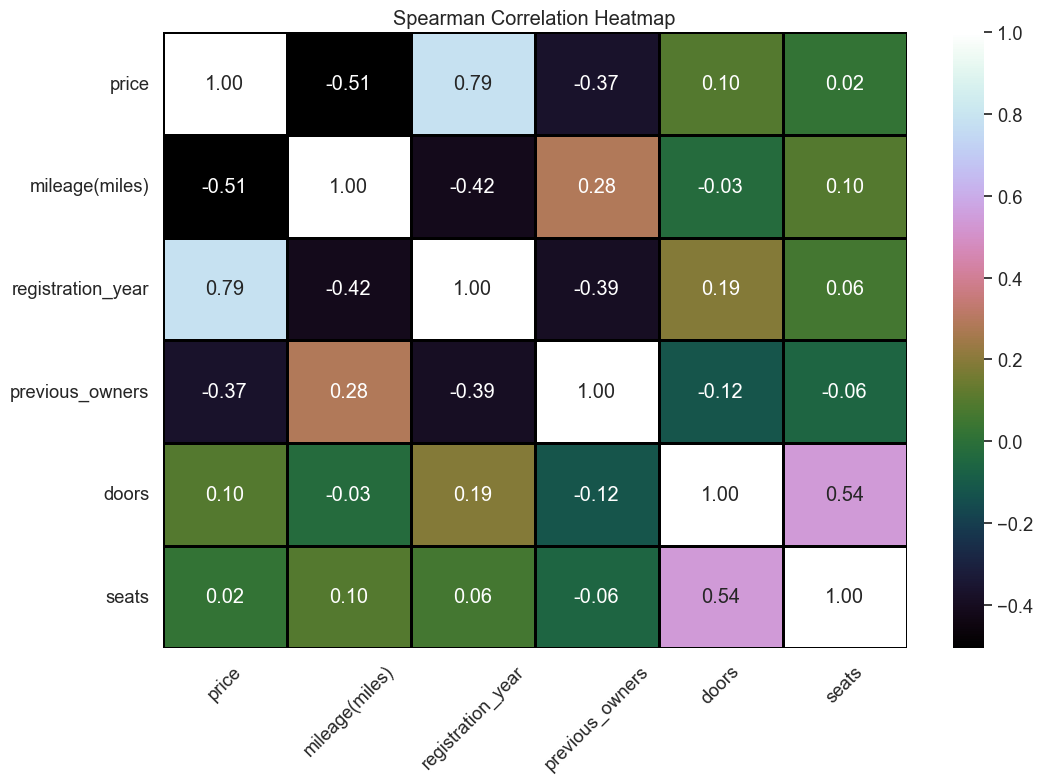

In [754]:
spearman_corr = df.corr(method='spearman', numeric_only=True)

plt.figure(figsize=(12, 8))
sns.set(font_scale=1.2)
sns.heatmap(spearman_corr, annot=True, cmap='cubehelix', fmt=".2f", linewidths=1, linecolor='black')
plt.title('Spearman Correlation Heatmap')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

## Categorical Encoding using One hot encoder

In [755]:
df.duplicated().sum()

0

In [756]:
duplicates = df[df.duplicated(keep=False)]
len(duplicates)

0

In [757]:
df.isnull().sum()

brand                0
price                0
mileage(miles)       0
registration_year    0
previous_owners      0
fuel_type            0
body_type            0
engine               0
gearbox              0
doors                0
seats                0
emission_class       0
service_history      0
dtype: int64

### Building Model 

#### Pipeline to combine dealing with categorical features, scaling and training.

In [758]:
# Define Feature Types
ordinal_features = ['service_history', 'emission_class', 'engine']
nominal_features = ['brand', 'fuel_type', 'body_type', 'gearbox']
numeric_features = ['mileage(miles)', 'registration_year', 'previous_owners', 'doors', 'seats'] 

# Define the full list of engine sizes
engine_sizes = ['0.8l', '0.9l', '1.0l', '1.1l', '1.2l', '1.3l', '1.4l', '1.5l', '1.6l', '1.7l', 
                '1.8l', '1.9l', '2.0l', '2.1l', '2.2l', '2.3l', '2.4l', '2.5l', '2.6l', '2.7l', 
                '2.8l', '2.9l', '3.0l', '3.1l', '3.2l', '3.3l', '3.5l', '3.7l', '4.0l', '4.2l', 
                '4.3l', '4.4l', '4.8l', '5.0l', '5.5l', '6.3l']


# Define Preprocessing Steps
preprocessor = ColumnTransformer(
    transformers=[
        ('ordinal', OrdinalEncoder(categories=[['unknown', 'full'], 
                                               ['euro_1', 'euro_2', 'euro_3', 'euro_4', 'euro_5', 'euro_6'], engine_sizes]),  # Added full list of engine sizes
         ordinal_features),
        
        ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'), nominal_features),
        
         ('scale', make_pipeline(  # Using make_pipeline for scaling
            StandardScaler()
        ), numeric_features)
    ]
)





<div style="background-color:#00008b;font-size:40px; color:white;">  Split</div>


In [660]:
df.reset_index(inplace=True, drop=True)
X = df.drop('price', axis=1)
y=df.price
#y=np.log1p(df.price)
X.shape

(2859, 12)

In [661]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

In [662]:
X_train.shape, X_val.shape, X_test.shape, y_train.shape

((1715, 12), (572, 12), (572, 12), (1715,))

In [663]:
X_train.emission_class.unique()

array(['euro_5', 'euro_6', 'euro_4', 'euro_3', 'euro_2', 'euro_1'],
      dtype=object)

<div style="background-color:#00008b;font-size:40px; color:white;">Train</div>

## Base Model

In [664]:
def rmse(y, y_pred):
    se = (y - y_pred) ** 2
    mse = se.mean()
    return np.sqrt(mse)

In [665]:
y_mean=y_train.mean()
y_pred=[y_mean]*len(y_train)
RMSE=rmse(y_train, y_pred)
print(f'Root Mean Square Error {RMSE}')  # 4216

Root Mean Square Error 4139.595695142562


In [666]:
mae = mean_absolute_error(y_train,y_pred)
print(f'MAE on train data: {mae}')

MAE on train data: 3158.7001164480785


In [667]:
r2=r2_score(y_train, y_pred)
print(f'R Squared Score {r2}')

R Squared Score 0.0


#### Linear Regression

In [668]:
# Create the pipeline using make_pipeline
model_pipeline = make_pipeline(
    preprocessor,  # Preprocessing steps
    LinearRegression()
)


In [669]:
# Example: Fit the model pipeline with training data

model_pipeline.fit(X_train, y_train)

# Predict on new data
predictions_train = model_pipeline.predict(X_train)  
y_pred = model_pipeline.predict(X_val) 

C:\Users\user\miniconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [670]:
predictions.shape

(572,)

In [671]:
RMSE = np.sqrt(mean_squared_error(y_train, predictions_train))
print(f'Root Mean Square Error with training data {RMSE}')   # 1271.59   #1982.45 scaled, and normal price one hot and label  #dictvectorizer 1766

Root Mean Square Error with training data 1887.3687021079536


In [672]:
RMSE = np.sqrt(mean_squared_error(y_val, y_pred))
print(f'Root Mean Square Error with validation data {RMSE}')      # 2706.58   # 2694 s one hot normal price #dictvec 2594 no scale   #2109 random 42 and pipeline  # with log price 2357

Root Mean Square Error with validation data 1941.63234517438


In [673]:
r2=r2_score(y_val, predictions)
print(f'R Squared Score {r2}') # 0.5533

R Squared Score 0.7636229662095413


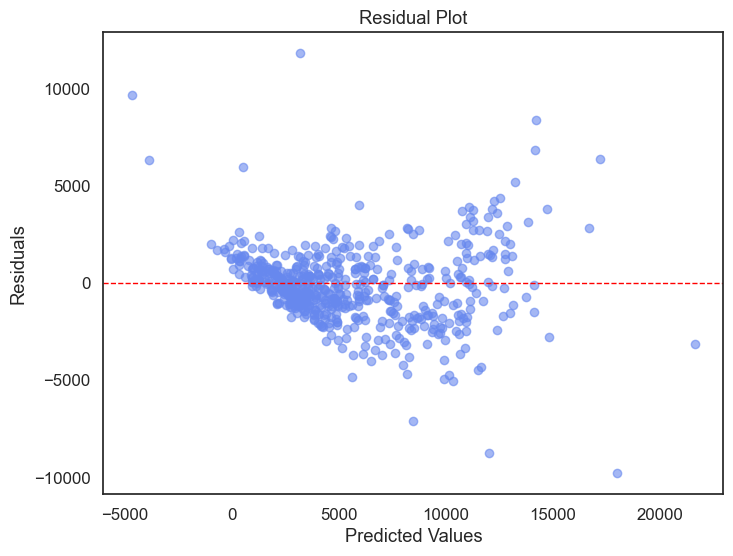

In [674]:
import matplotlib.pyplot as plt

residuals = y_val - y_pred
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()


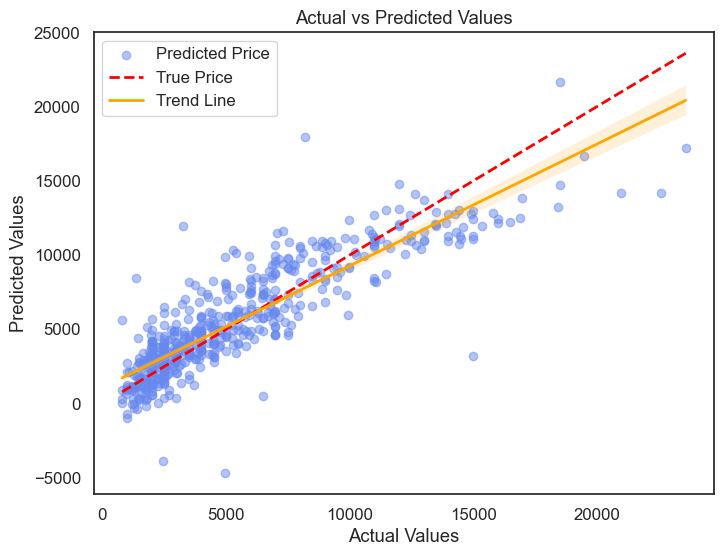

In [683]:
plt.figure(figsize=(8, 6))
plt.scatter(y_val, y_pred, alpha=0.5, label='Predicted Price')
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], color='red', linestyle='--', linewidth=2, label='True Price')
sns.regplot(x=y_val, y=predictions, scatter=False, color='r', line_kws={"color": "orange", "lw": 2}, label='Trend Line', ci=95)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.show()


## Regularization

In [685]:
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge
import numpy as np

# Define the regularization strength values
alpha = [10, 11, 12, 13, 14,15,16,17,18,19,20]

# Initialize lists to store results for analysis
results = []

# Iterate over different alpha values
for i in alpha:
    # Create the pipeline using make_pipeline with your preprocessor and Ridge regression
    model_pipeline = make_pipeline(
        preprocessor,  # Custom preprocessing steps
        Ridge(alpha=i)  # Ridge regression with specific alpha
    )
    
    # Fit the model
    model_pipeline.fit(X_train, y_train)
    
    # Predict and evaluate
    y_pred = model_pipeline.predict(X_val)
    RMSE = np.sqrt(mean_squared_error(y_val, y_pred))
    r2 = r2_score(y_val, y_pred)
    
    # Store results
    results.append({'alpha': i, 'RMSE': RMSE, 'R2': r2})
    
    # Print results for this alpha
    print(f'Alpha: {i}')
    print(f'Root Mean Square Error: {RMSE:.2f}')
    print(f'R2 Score: {r2:.4f}')
    print('-' * 50)

# Display all results in tabular format for better comparison
import pandas as pd
results_df = pd.DataFrame(results)
print(results_df)


C:\Users\user\miniconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\user\miniconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\user\miniconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\user\miniconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Alpha: 10
Root Mean Square Error: 1858.57
R2 Score: 0.7842
--------------------------------------------------
Alpha: 11
Root Mean Square Error: 1858.39
R2 Score: 0.7843
--------------------------------------------------
Alpha: 12
Root Mean Square Error: 1858.34
R2 Score: 0.7843
--------------------------------------------------
Alpha: 13
Root Mean Square Error: 1858.41
R2 Score: 0.7843
--------------------------------------------------


C:\Users\user\miniconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\user\miniconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\user\miniconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Alpha: 14
Root Mean Square Error: 1858.64
R2 Score: 0.7842
--------------------------------------------------
Alpha: 15
Root Mean Square Error: 1858.83
R2 Score: 0.7842
--------------------------------------------------
Alpha: 16
Root Mean Square Error: 1859.07
R2 Score: 0.7841
--------------------------------------------------
Alpha: 17
Root Mean Square Error: 1859.37
R2 Score: 0.7840
--------------------------------------------------


C:\Users\user\miniconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\user\miniconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\user\miniconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Alpha: 18
Root Mean Square Error: 1859.69
R2 Score: 0.7840
--------------------------------------------------
Alpha: 19
Root Mean Square Error: 1859.94
R2 Score: 0.7839
--------------------------------------------------
Alpha: 20
Root Mean Square Error: 1860.33
R2 Score: 0.7838
--------------------------------------------------
    alpha         RMSE        R2
0      10  1858.570588  0.784225
1      11  1858.391291  0.784267
2      12  1858.344081  0.784278
3      13  1858.406714  0.784263
4      14  1858.644343  0.784208
5      15  1858.827074  0.784166
6      16  1859.066259  0.784110
7      17  1859.369600  0.784040
8      18  1859.691360  0.783965
9      19  1859.935088  0.783908
10     20  1860.326216  0.783818


C:\Users\user\miniconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


### Result
Ridge improved the R2 Score from 0.76 to 0.784 and RMSE from 1941 to 1859

### RandomForestRegressor

In [688]:
# Create the pipeline using make_pipeline
model_pipeline = make_pipeline(
    preprocessor,  # Preprocessing steps
    RandomForestRegressor()
)

In [689]:
# Example: Fit the model pipeline with training data

model_pipeline.fit(X_train, y_train)

# Predict on new data
y_pred = model_pipeline.predict(X_val) 

C:\Users\user\miniconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [623]:
RMSE = np.sqrt(mean_squared_error(y_val, y_pred))
r2=r2_score(y_val, y_pred)
print(f'Root Mean Square Error with validation data {RMSE}') 
print(f'R2 Score:{r2}')     #1500, 0.85  

Root Mean Square Error with validation data 1507.6050704669926
R2 Score:0.8580231990948032


In [691]:
import time

# Define the hyperparameter ranges for tuning
param_grid = {
    'randomforestregressor__n_estimators': range(50, 201, 50),  # Number of trees: 50, 100, 150, 200
    'randomforestregressor__max_depth': range(5, 21, 5),        # Depth of the tree: 5, 10, 15, 20
    'randomforestregressor__min_samples_split': range(2, 11, 2), # Minimum samples to split: 2, 4, 6, 8, 10
    'randomforestregressor__min_samples_leaf': range(1, 6),      # Minimum samples per leaf: 1, 2, 3, 4, 5
}

# Create the pipeline using make_pipeline
model_pipeline = make_pipeline(
    preprocessor,  # Preprocessing steps
    RandomForestRegressor(random_state=42)
)

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=model_pipeline,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',  # Scoring metric for regression
    cv=3,                              # 3-fold cross-validation
    n_jobs=-1,                         # Use all available CPU cores
    verbose=2                          # Show progress
)

# Measure the time before starting the grid search
start_time = time.time()

# Fit the grid search
grid_search.fit(X_train, y_train)

# Measure the time after grid search
end_time = time.time()

# Calculate the time taken in seconds
time_taken = end_time - start_time

# Get the best hyperparameters and the corresponding score
best_params = grid_search.best_params_
best_score = np.sqrt(-grid_search.best_score_)  # Convert negative MSE to RMSE

# Print the results
print("Best Hyperparameters:", best_params)
print(f"Best RMSE: {best_score:.2f}")
print(f"Time Taken: {time_taken:.2f} seconds")

# Evaluate on validation/test set
best_model = grid_search.best_estimator_
y_val_pred = best_model.predict(X_val)

rmse_val = np.sqrt(mean_squared_error(y_val, y_val_pred))
r2_val = r2_score(y_val, y_val_pred)

print(f"Validation RMSE: {rmse_val:.2f}")
print(f"Validation R2 Score: {r2_val:.2f}")

Fitting 3 folds for each of 400 candidates, totalling 1200 fits


C:\Users\user\miniconda3\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best Hyperparameters: {'randomforestregressor__max_depth': 20, 'randomforestregressor__min_samples_leaf': 1, 'randomforestregressor__min_samples_split': 4, 'randomforestregressor__n_estimators': 150}
Best RMSE: 1655.76
Time Taken: 485.65 seconds
Validation RMSE: 1417.59
Validation R2 Score: 0.87


C:\Users\user\miniconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Best Hyperparameters: {'randomforestregressor__max_depth': 20, 'randomforestregressor__min_samples_leaf': 1, 'randomforestregressor__min_samples_split': 4, 'randomforestregressor__n_estimators': 150}   
Best RMSE: 1655.76  
Time Taken: 485.65 seconds   
Validation RMSE: 1417.59   
Validation R2 Score: 0.87   


In [692]:
import pickle  # Import the pickle module

# ... (previous code remains the same)

# Save the best model after fitting the grid search
best_model = grid_search.best_estimator_

# Save the best model to a file using pickle
with open('car_price_predictor/best_random_forest_model.pkl', 'wb') as file:
    pickle.dump(best_model, file)

print("Best model saved to 'best_random_forest_model.pkl'")


Best model saved to 'best_random_forest_model.pkl'


In [698]:
# To load the saved model
with open('car_price_predictor/best_random_forest_model.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

# Use the loaded model to make predictions
y_pred = loaded_model.predict(X_test)
#y_pred
print(loaded_model)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('ordinal',
                                                  OrdinalEncoder(categories=[['unknown',
                                                                              'full'],
                                                                             ['euro_1',
                                                                              'euro_2',
                                                                              'euro_3',
                                                                              'euro_4',
                                                                              'euro_5',
                                                                              'euro_6'],
                                                                             ['0.8l',
                                                                              '0.9l',
                        

C:\Users\user\miniconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


### Deep Learning


In [131]:
# Create the pipeline with scaling and MLPRegressor
model_pipeline = make_pipeline(
    preprocessor,  # Scaling the data
    MLPRegressor(hidden_layer_sizes=(128, 64), random_state=42, max_iter=2000, solver='adam',  learning_rate_init=0.001)  # MLPRegressor
)

# Fit the model
model_pipeline.fit(X_train, y_train)

# Predict using the trained model
y_pred = model_pipeline.predict(X_val)

# Evaluate the model
RMSE = np.sqrt(mean_squared_error(y_val, y_pred))
r2 = r2_score(y_val, y_pred)  # R^2 Score
print(f'Root Mean Squared Error: {RMSE}')
print(f'R2 Score: {r2}')

Root Mean Squared Error: 1329.0611385553582
R2 Score: 0.8896602167790103


C:\Users\user\miniconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\user\miniconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [118]:
from sklearn.model_selection import GridSearchCV
# Define the parameter grid for MLPRegressor
param_grid = {
    'mlpregressor__hidden_layer_sizes': [(100,), (50, 50), (100, 100)],  # Different layer sizes
    'mlpregressor__activation': ['relu', 'tanh'],  # Different activation functions
    'mlpregressor__solver': ['adam', 'sgd'],  # Optimizers
    'mlpregressor__alpha': [0.0001, 0.001, 0.01],  # Regularization strength
    'mlpregressor__learning_rate': ['constant', 'adaptive'],  # Learning rate schedule
}

# Create the pipeline with scaling and MLPRegressor
pipeline = make_pipeline(
    preprocessor,  # processing steps
    MLPRegressor(max_iter=500, random_state=42)  # MLP Regressor with max iterations set
)

# Setup GridSearchCV
grid_search = GridSearchCV(
    pipeline, 
    param_grid, 
    cv=3,  # Cross-validation
    n_jobs=-1,  # Use all available processors
    verbose=1,
    scoring='neg_mean_squared_error'  # We are minimizing the error
)

# Fit GridSearchCV to training data
grid_search.fit(X_train, y_train)

# Get best parameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Evaluate the best model on validation data
y_pred = best_model.predict(X_val)

# Calculate RMSE and R2 Score
from sklearn.metrics import mean_squared_error, r2_score
RMSE = np.sqrt(mean_squared_error(y_val, y_pred))
R2 = r2_score(y_val, y_pred)

print(f"Best parameters: {best_params}")
print(f"Root Mean Square Error: {RMSE}")
print(f"R2 Score: {R2}")

Fitting 3 folds for each of 72 candidates, totalling 216 fits


C:\Users\user\miniconda3\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
30 fits failed out of a total of 216.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\user\miniconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\miniconda3\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\user\miniconda3\Lib\site-packages\sklearn\pipeline.py", line 473, in fit
    self._final_estimator.fi

Best parameters: {'mlpregressor__activation': 'relu', 'mlpregressor__alpha': 0.01, 'mlpregressor__hidden_layer_sizes': (100, 100), 'mlpregressor__learning_rate': 'constant', 'mlpregressor__solver': 'adam'}
Root Mean Square Error: 1353.8814725390707
R2 Score: 0.8855005244285576


C:\Users\user\miniconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\user\miniconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [113]:
model = Sequential()
model.add(Input(shape=(X_train.shape[1],)))  # Define the input shape explicitly
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))  
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))  
model.add(Dense(1, activation='linear'))

In [121]:
# Check for NaN values in the dataset
# if np.any(np.isnan(X_train)) or np.any(np.isnan(y_train)):
#     print("Data contains NaN values.")

# Check for infinite values in the dataset
if np.any(np.isinf(X_train)) or np.any(np.isinf(y_train)):
    print("Data contains infinite values.")

TypeError: ufunc 'isinf' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [114]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [115]:
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, verbose=1)

ValueError: Invalid dtype: object

In [116]:
loss = model.evaluate(X_val, y_val, verbose=0)
loss

ValueError: Invalid dtype: object

In [112]:
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning Curve: Training vs Validation Loss')
plt.legend()
plt.show()


NameError: name 'history' is not defined

<Figure size 800x600 with 0 Axes>

In [ ]:
predictions = model.predict(X_test)

In [ ]:
mae = mean_absolute_error(y_test, predictions)
print(f'MAE on test data: {mae}')   #1000

In [ ]:
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f'RMSE on test data: {rmse}')  #1576

In [ ]:
mean_squared_error(y_test, predictions)

In [ ]:
r2 = r2_score(y_test, predictions)
print(f'R-squared value on test data: {r2}')